In [5]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, f1_score

## Loading Data

In [3]:
# Load the dataset
df = pd.read_csv('../../wine_development(in).csv', sep=',')
df.sample(5)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,color,wine_id
31,6.7,0.675,0.07,2.4,0.089,17.0,82.0,0.99580,3.35,0.54,10.1,5,red,1687
954,6.5,0.210,0.42,1.1,0.059,33.0,101.0,0.99270,3.12,0.38,9.7,6,white,3319
3286,6.2,0.190,0.29,4.3,0.045,33.0,126.0,0.99658,3.18,0.42,9.3,6,white,636
3715,7.3,0.270,0.30,1.3,0.040,26.0,84.0,0.99222,3.28,0.53,10.7,6,white,2615
3631,5.9,0.370,0.10,1.6,0.057,39.0,128.0,0.99240,3.24,0.48,10.1,5,white,1655


## Data Inspection and Cleaning

In [25]:
df

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,color,wine_id
0,5.8,0.31,0.32,4.5,0.024,28.0,94.0,0.98906,3.25,0.52,13.70,7,white,1198
1,6.3,0.13,0.42,1.1,0.043,63.0,146.0,0.99066,3.13,0.72,11.20,7,white,3409
2,8.2,0.30,0.44,12.4,0.043,52.0,154.0,0.99452,3.04,0.33,12.00,6,white,4789
3,9.4,0.17,0.55,1.6,0.049,14.0,94.0,0.99490,3.02,0.61,10.30,6,white,3054
4,5.3,0.30,0.16,4.2,0.029,37.0,100.0,0.99050,3.30,0.36,11.80,8,white,2812
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4151,6.3,0.41,0.22,7.3,0.035,23.0,117.0,0.99172,3.20,0.39,11.94,7,white,1900
4152,6.7,0.34,0.40,2.1,0.033,34.0,111.0,0.98924,2.97,0.48,12.20,7,white,1861
4154,5.9,0.20,0.40,1.3,0.047,23.0,92.0,0.99232,3.20,0.45,10.00,6,white,3328
4155,7.3,0.32,0.35,1.4,0.050,8.0,163.0,0.99244,3.24,0.42,10.70,5,white,2738


In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3751 entries, 0 to 4156
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         3751 non-null   float64
 1   volatile acidity      3751 non-null   float64
 2   citric acid           3751 non-null   float64
 3   residual sugar        3751 non-null   float64
 4   chlorides             3751 non-null   float64
 5   free sulfur dioxide   3751 non-null   float64
 6   total sulfur dioxide  3751 non-null   float64
 7   density               3751 non-null   float64
 8   pH                    3751 non-null   float64
 9   sulphates             3751 non-null   float64
 10  alcohol               3751 non-null   float64
 11  quality               3751 non-null   int64  
 12  color                 3751 non-null   object 
 13  wine_id               3751 non-null   int64  
dtypes: float64(11), int64(2), object(1)
memory usage: 439.6+ KB


In [27]:
# Create table
data = df.copy()

def format_example_values(series):
    vals = series.dropna().unique()[:5]
    
    formatted = []
    for v in vals:
        if isinstance(v, (int, float, np.number)):
            formatted.append(f"{v:.2f}")
        else:
            formatted.append(str(v))
    return ", ".join(formatted)

summary_df = pd.DataFrame({
    "Feature/variable": data.columns,
    "Data type": data.dtypes.values.astype(str),
    "Number of Unique values": [data[col].nunique() for col in data.columns],
    "Example values": [format_example_values(data[col]) for col in data.columns]
})

# Show all rows without truncation
with pd.option_context("display.max_rows", None, "display.max_colwidth", None):
    print(summary_df.to_markdown(index=False))

| Feature/variable     | Data type   |   Number of Unique values | Example values                              |
|:---------------------|:------------|--------------------------:|:--------------------------------------------|
| fixed acidity        | float64     |                       102 | 5.80, 6.30, 8.20, 9.40, 5.30                |
| volatile acidity     | float64     |                       167 | 0.31, 0.13, 0.30, 0.17, 0.24                |
| citric acid          | float64     |                        87 | 0.32, 0.42, 0.44, 0.55, 0.16                |
| residual sugar       | float64     |                       282 | 4.50, 1.10, 12.40, 1.60, 4.20               |
| chlorides            | float64     |                       179 | 0.02, 0.04, 0.05, 0.03, 0.05                |
| free sulfur dioxide  | float64     |                       117 | 28.00, 63.00, 52.00, 14.00, 37.00           |
| total sulfur dioxide | float64     |                       256 | 94.00, 146.00, 154.00, 100.00

In [23]:
# Create table for numeric columns
# numeric variables only (target + predictors)
# Drop Overall rank
data = data.drop(columns=["Overall rank"], errors='ignore')
numeric_cols = data.select_dtypes(include=['float64', 'int64']).columns

# Basic descriptive statistics
desc = data[numeric_cols].describe().rename(index={
    "50%": "50%",
    "25%": "25%",
    "75%": "75%"
})

# Add variance
desc.loc["Variance"] = data[numeric_cols].var()

# Add dispersion index = variance / mean
dispersion_index = data[numeric_cols].var() / data[numeric_cols].mean()
desc.loc["Dispersion index (Variance / Mean)"] = dispersion_index

# Reorder rows to match your required format
row_order = [
    "count", "mean", "std", "min", "25%", "50%", "75%", "max",
    "Variance", "Dispersion index (Variance / Mean)"
]
desc = desc.loc[row_order]

# Convert to Markdown
md_table = desc.to_markdown(tablefmt="pipe", floatfmt=".2f")
print(md_table)

|                                    |   fixed acidity |   volatile acidity |   citric acid |   residual sugar |   chlorides |   free sulfur dioxide |   total sulfur dioxide |   density |      pH |   sulphates |   alcohol |   quality |    wine_id |
|:-----------------------------------|----------------:|-------------------:|--------------:|-----------------:|------------:|----------------------:|-----------------------:|----------:|--------:|------------:|----------:|----------:|-----------:|
| count                              |         3948.00 |            3948.00 |       3948.00 |          3948.00 |     3948.00 |               3948.00 |                3948.00 |   3948.00 | 3948.00 |     3948.00 |   3948.00 |   3948.00 |    3948.00 |
| mean                               |            7.20 |               0.34 |          0.32 |             5.40 |        0.06 |                 30.36 |                 115.53 |      0.99 |    3.22 |        0.53 |     10.49 |      5.83 |    2577.78 |
| st

In [26]:
# Descriptive table for categorical variables

cat_desc = pd.DataFrame(index=categorical_cols, columns=[
    "Unique Values"
])

for col in categorical_cols:
    counts = data[col].value_counts(dropna=False)
    most_freq_val = counts.idxmax()
    freq = counts.max()
    perc = freq / counts.sum() * 100

    cat_desc.loc[col] = [
        data[col].nunique()
    ]

# Convert to Markdown
md_table_cat = cat_desc.to_markdown(tablefmt="pipe", floatfmt=".2f")
print(md_table_cat)

|       |   Unique Values |
|:------|----------------:|
| color |               2 |


In [16]:
# Check for outliers using OneClassSVM
from sklearn.svm import OneClassSVM
oc_svm = OneClassSVM(nu=0.05, kernel='rbf', gamma='scale')
outliers = oc_svm.fit_predict(df.select_dtypes(include=['float64', 'int64']))
df['outlier'] = outliers
print(f"Number of outliers detected: {(df['outlier'] == -1).sum()}")

Number of outliers detected: 197


In [17]:
# Handle outliers based on OneClassSVM results
df = df[df['outlier'] != -1]
df.drop('outlier', axis=1, inplace=True)

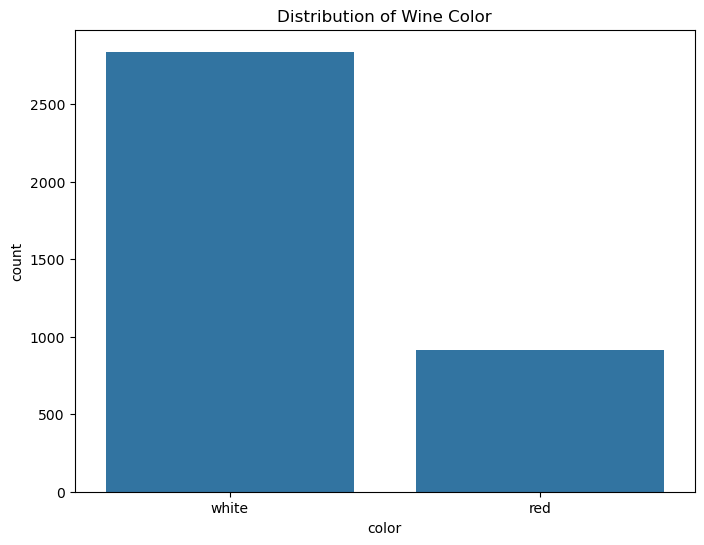

In [18]:
# Check for balanced classes
plt.figure(figsize=(8, 6))
sns.countplot(x='color', data=df)
plt.title("Distribution of Wine Color")
plt.show()

In [19]:
# Split dataset into training and testing sets
X = df.drop('color', axis=1)
y = df['color']

# Use a single stratified train/test split to create a stable holdout set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
print('Train samples:', X_train.shape[0], 'Test samples:', X_test.shape[0])

Train samples: 3000 Test samples: 751


In [20]:
# Scale your features for visualization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

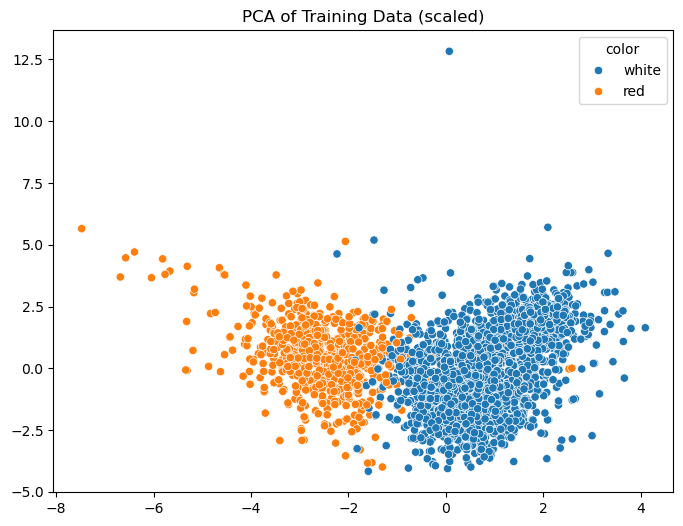

In [21]:
# PCA Visualization (use scaled features)
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
# use the scaled training data for PCA so components aren't dominated by scale
X_train_pca = pca.fit_transform(X_train_scaled)
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_train_pca[:, 0], y=X_train_pca[:, 1], hue=y_train)
plt.title("PCA of Training Data (scaled)")
plt.show()

In [14]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# split once (stratify to preserve class balance)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', SVC())
])

param_grid = {
    'svc__C': [0.01, 0.1, 1, 10],
    'svc__kernel': ['linear', 'rbf', 'poly'],
    'svc__gamma': ['scale', 'auto']
}

gs = GridSearchCV(pipe, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
gs.fit(X_train, y_train)

print("Best CV score:", gs.best_score_)
print("Test accuracy:", gs.score(X_test, y_test))
print("Test classification report:\n", classification_report(y_test, gs.predict(X_test)))

Best CV score: 0.9946157395333909
Test accuracy: 0.9974683544303797
Test classification report:
               precision    recall  f1-score   support

         red       1.00      0.99      0.99       192
       white       1.00      1.00      1.00       598

    accuracy                           1.00       790
   macro avg       1.00      0.99      1.00       790
weighted avg       1.00      1.00      1.00       790

